<a href="https://colab.research.google.com/github/comb0601/deepfake/blob/master/deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import glob
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage import measure


In [14]:
#TEST_PATH = '/content/'
TRAIN_PATH = '/content/'

#metadata = '../input/deepfake-detection-challenge/train_sample_videos/metadata.json'

In [15]:
# load the filenames for train videos
train_fns = sorted(glob.glob('*.mp4'))

# load the filenames for test videos
#test_fns = sorted(glob.glob(TEST_PATH + '*.mp4'))

print('There are {} samples in the train set.'.format(len(train_fns)))
#print('There are {} samples in the test set.'.format(len(test_fns)))

There are 2 samples in the train set.


In [16]:
is_fake = True

def get_frames(filename):
    '''
    Get all frames from the video
    INPUT:
        filename - video filename
    OUTPUT:
        frames - the array of video frames
    '''
    frames = []
    global is_fake
    cap = cv2.VideoCapture(filename)
    if filename.startswith("fake"):
        is_fake = True

    #while(cap.isOpened()):
    while len(frames) < 300 :
        ret, frame = cap.read()
                
        if not ret:
            break;
            
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(image)

    cap.release()
    cv2.destroyAllWindows()
    return frames



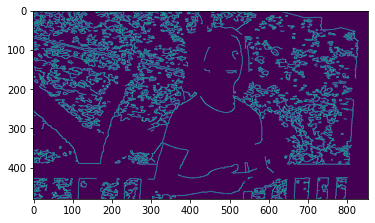

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

frames = get_frames(train_fns[0])

edge = cv2.Canny(frames[200], 150, 300)
plt.imshow(edge)
plt.show()

In [26]:
np.shape(frames)

(243, 480, 854, 3)

In [19]:
'''
output = open('result_org.csv', 'w')
output.write('r,g,b\n')

for i in range(len(frames)) :
  image = frames[i]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RGB 형태로 변환
  image = image.reshape((image.shape[0] * image.shape[1], 3))
  k = 1 
  clt = KMeans(n_clusters = k)
  clt.fit(image)
  for center in clt.cluster_centers_:
    print(center)
    output.write(str(center[0]) + ',' + str(center[1]) + ',' + str(center[2]) + '\n')
'''

"\noutput = open('result_org.csv', 'w')\noutput.write('r,g,b\n')\n\nfor i in range(len(frames)) :\n  image = frames[i]\n  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RGB 형태로 변환\n  image = image.reshape((image.shape[0] * image.shape[1], 3))\n  k = 1 \n  clt = KMeans(n_clusters = k)\n  clt.fit(image)\n  for center in clt.cluster_centers_:\n    print(center)\n    output.write(str(center[0]) + ',' + str(center[1]) + ',' + str(center[2]) + '\n')\n"

In [20]:
def calcRGBCenter(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RGB 형태로 변환
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    k = 1
    clt = KMeans(n_clusters = k)
    clt.fit(image)

    return clt.cluster_centers_[0]


def calcHSVCenter(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #HSV 형태로 변환
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    k = 1
    clt = KMeans(n_clusters = k)
    clt.fit(image)

    return clt.cluster_centers_[0]

In [21]:
'''
output = open('result_org.csv', 'w')
output.write('r,g,b\n')

for i in range(len(frames)) :
  image = frames[i]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #HSV 형태로 변환
  image = image.reshape((image.shape[0] * image.shape[1], 3))
  k = 1 
  clt = KMeans(n_clusters = k)
  clt.fit(image)
  for center in clt.cluster_centers_:
    print(center)
    output.write(str(center[0]) + ',' + str(center[1]) + ',' + str(center[2]) + '\n')
'''

"\noutput = open('result_org.csv', 'w')\noutput.write('r,g,b\n')\n\nfor i in range(len(frames)) :\n  image = frames[i]\n  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #HSV 형태로 변환\n  image = image.reshape((image.shape[0] * image.shape[1], 3))\n  k = 1 \n  clt = KMeans(n_clusters = k)\n  clt.fit(image)\n  for center in clt.cluster_centers_:\n    print(center)\n    output.write(str(center[0]) + ',' + str(center[1]) + ',' + str(center[2]) + '\n')\n"

In [22]:
def get_image_difference(image_1, image_2):  # 히스토그램 차이
    first_image_hist = cv2.calcHist([image_1], [0], None, [256], [0, 256])
    second_image_hist = cv2.calcHist([image_2], [0], None, [256], [0, 256])

    img_hist_diff = cv2.compareHist(first_image_hist, second_image_hist, cv2.HISTCMP_BHATTACHARYYA)
    img_template_probability_match = cv2.matchTemplate(first_image_hist, second_image_hist, cv2.TM_CCOEFF_NORMED)[0][0]
    img_template_diff = 1 - img_template_probability_match

    # taking only 10% of histogram diff, since it's less accurate than template method
    commutative_image_diff = (img_hist_diff / 10) + img_template_diff
    return commutative_image_diff

In [23]:
resfile = open("result.csv", "a")
resfile.write("mse,psnr,ssim,hist_diff,r_diff,g_diff,b_diff,h_diff,s_diff,v_diff,deepfake\n")

for i in range(len(frames)-1) :  #PSNR 값
    img1 = frames[i] # 첫 프레임
    img2 = frames[i+1] #다음 프레임

    mse = np.sum((img1.astype("float") - img2.astype("float")) ** 2) #MSE
    mse /= float(img1.shape[0] * img1.shape[1])

    psnr = cv2.PSNR(img1, img2) # 프레임 간 PSNR값

    ssim = measure.compare_ssim(img1, img2,multichannel=True) # SSIM 멀티채널 오픈필요

    histogram_diff = get_image_difference(img1,img2) # 프레임간 히스토그램 차이

    rgb_diff = abs(calcRGBCenter(img2) - calcRGBCenter(img1))

    hsv_diff = abs(calcHSVCenter(img2) - calcHSVCenter(img1))

    resfile.write(
        str(mse) + ',' + str(psnr) + ',' + str(ssim) + ',' + str(histogram_diff) + ',' +
        str(rgb_diff[0]) + ',' + str(rgb_diff[1]) + ',' + str(rgb_diff[2]) + ',' +
        str(hsv_diff[0]) + ',' + str(hsv_diff[1]) + ',' + str(hsv_diff[2]) + ',' + str(is_fake) + '\n'
    )



c:\users\junhyeok\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
c:\users\junhyeok\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
c:\users\junhyeok\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
c:\users\junhyeok\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measu